In [1]:
in_path = "../data/processed/data_model_master.pkl"
out_model_path = "../model/"
out_eval_path = "../data/evaluation/"

In [2]:
from os.path import dirname
import os, sys, inspect

currentdir = os.getcwd()
parentdir = dirname(currentdir)

sys.path.insert(0,parentdir)

# Libs

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt 
import seaborn as sns 

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

from src.utils import dump_to_pickle
from src.evaluate import create_eval_df, plot_feature_importance

In [5]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

# Load Data

In [6]:
data = pd.read_pickle(in_path)

In [7]:
data.head()

,hs_eng,hs_math,hs_bio,hs_chem,hs_phy,hs_econ,hs_geo,hs_soc,hs_final,major_name,school_prop,school_geo_unit,school_state,faculty,fail
0,-1.048565,-0.848793,-1.031378,-1.030655,-1.030533,1.223719,0.889068,1.019979,-0.152911,14,4,6,33,0,0
1,-0.451131,-1.541255,-1.031378,-1.030655,-1.030533,1.041207,1.045342,0.945211,-1.307819,14,4,0,7,0,1
2,-1.446854,-1.310434,-1.031378,-1.030655,-1.030533,1.047501,0.982833,1.094747,-0.962537,14,4,7,21,0,0
3,0.146302,0.795803,-1.031378,-1.030655,-1.030533,0.852403,0.989084,0.857982,-0.724412,14,4,0,9,0,0
4,0.544591,-0.012069,0.937199,0.833885,0.921328,-0.953830,-0.954972,-0.955133,0.585277,14,5,5,27,0,0


In [8]:
data = data.drop(['school_prop',
                  'school_geo_unit',
                  'school_state',
                  'faculty'], axis=1)

# Train-Test Split

In [9]:
X = data.drop('fail', axis=1)
y = data['fail']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=187)

In [11]:
print("Train Size: ", X_train.shape[0])
print("Test Size: ", X_test.shape[0])

Train Size:  1407
Test Size:  694


# Imbalance Resampling

In [12]:
y_train.value_counts(normalize=True)

0    0.900498
1    0.099502
Name: fail, dtype: float64

In [13]:
target_ratio = 0.5

sm = SMOTE(random_state=187,
           ratio={
               0:y_train.value_counts()[0],
               1:int(y_train.value_counts()[0]*(target_ratio/(1-target_ratio)))
           })

In [14]:
X_train_upsampled, y_train_upsampled = sm.fit_sample(X_train, y_train)

In [15]:
sum(y_train_upsampled)/len(y_train_upsampled)

0.5

# Logistic Regression

In [16]:
from sklearn.linear_model import LogisticRegression

In [17]:
log_model = LogisticRegression(random_state=100).fit(X_train_upsampled, y_train_upsampled)

#save model
dump_to_pickle(log_model, out_model_path+'log_model.pkl')

In [18]:
log_train_pred = log_model.predict_proba(X_train)
log_test_pred = log_model.predict_proba(X_test)

In [19]:
log_eval_train, log_eval_test, log_eval_data = create_eval_df(log_train_pred, log_test_pred, y_train, y_test)

#save eval data
log_save_objs = log_eval_data, log_eval_train, log_eval_test
dump_to_pickle(log_save_objs, out_eval_path+'log_eval.pkl')

# Random Forest 

In [20]:
from sklearn.ensemble import RandomForestClassifier

In [21]:
RF_model = RandomForestClassifier(max_depth=3, random_state=100).fit(X_train_upsampled, y_train_upsampled)

#save model
dump_to_pickle(RF_model, out_model_path+'RF_model.pkl')

In [22]:
RF_train_pred = RF_model.predict_proba(X_train)
RF_test_pred = RF_model.predict_proba(X_test)

In [23]:
RF_eval_train, RF_eval_test, RF_eval_data = create_eval_df(RF_train_pred, RF_test_pred, y_train, y_test)

#save eval data
RF_save_objs = RF_eval_data, RF_eval_train, RF_eval_test
dump_to_pickle(RF_save_objs, out_eval_path+'RF_eval.pkl')

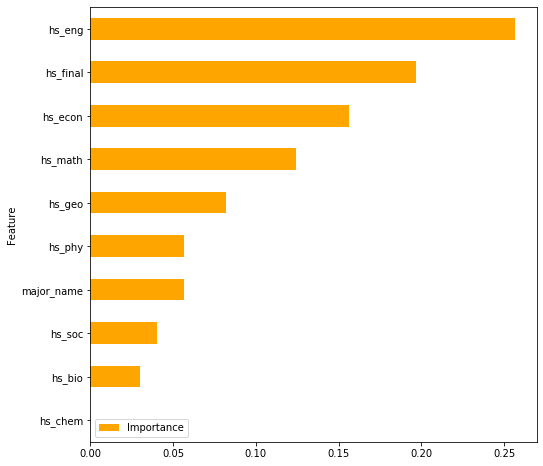

In [24]:
plot_feature_importance(RF_model, X.keys())

# Support Vector Machines

In [25]:
from sklearn.svm import SVC

In [26]:
SVC_model = SVC(probability=True, random_state=100).fit(X_train_upsampled, y_train_upsampled)

#save model
dump_to_pickle(SVC_model, out_model_path+'SVC_model.pkl')

In [27]:
SVC_train_pred = SVC_model.predict_proba(X_train)
SVC_test_pred = SVC_model.predict_proba(X_test)

In [28]:
SVC_eval_train, SVC_eval_test, SVC_eval_data = create_eval_df(SVC_train_pred, SVC_test_pred, y_train, y_test)

#save eval data
SVC_save_objs = SVC_eval_data, SVC_eval_train, SVC_eval_test
dump_to_pickle(SVC_save_objs, out_eval_path+'SVC_eval.pkl')